# Package Import 

In [1]:
# general packages 
import numpy as np 
import math
import pandas as pd
import time 

In [2]:
# GIS packages 
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
import geopandas as gpd
from IPython.display import Image, display

In [3]:
# specific packages 
import googlemaps 

In [4]:
# visualization packages 
import matplotlib.pyplot as plt 
from IPython.display import Image, display
import folium 

In [2]:
# custom functions 
from POI_Functions import cordinate_findings

#  GRID Creation

In [56]:
def second_cordiante(bearing,distance,in_lat,in_long):
    
    """ 
    return the second set of cordiantes given a base set of cordinates refering the bearing and distance 
    
    dependencies 
    ----------
    pandas 
    math 
    
    Parameters
    ----------
    bearing -  angle of the second set relative to the original set 
    distance -  linear distance to the second cordinate from the first 
    in_lat - latitude of the first cordiante 
    in_long - longitude of the first cordiante
    
    Returns
    -------
    return the second set of cordiantes  
    
    """   
    
    i = bearing  ## simplify the bearing variable 
 
    R = 6378.1 #Radius of the Earth
    brng = i*(3.14/180)
    d = distance #Distance in km

    lat1 = math.radians(in_lat) #Current lat point converted to radians
    lon1 = math.radians(in_long) #Current long point converted to radians
   
    ## calculation 
    lat2 = math.asin(math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2) ## estimated lat point from radians convert to degrees 
    lon2 = math.degrees(lon2) ## estimated lang point from radians convert to degrees 
    
    new_out = [lat2,lon2] ## take the output for an array 
    
    return new_out

### Creating the base structure

for the selected study area - 

In [95]:
rows = 30
cols = 44

xmin = 79.82077233
ymax = 6.98103934

grid_length = 1.05 
grid_diagnal = np.sqrt((grid_length*grid_length) + (grid_length*grid_length))

polygons = []

for i in range(cols):
    
    if i == 0:
    
        x_in_col = xmin
        y_in_col = ymax
        
    else:
        
        distance = 1.05*i
        column_cordinates = second_cordiante(90,distance,ymax,xmin)
        x_in_col = column_cordinates[1]
        y_in_col = column_cordinates[0]
    
    row_num = 1
    
    for j in range(rows):
        
        x_in = x_in_col
        y_in = y_in_col
        
        if row_num % 2 == 0:
            new_cordinates = second_cordiante(225,grid_diagnal,y_in,x_in)
            xmax = new_cordinates[1]
            ymin = new_cordinates[0]
            polygons.append(box(x_in,ymin,xmax,y_in))
            
        else:
            new_cordinates = second_cordiante(135,grid_diagnal,y_in,x_in)
            xmax = new_cordinates[1]
            ymin = new_cordinates[0]
            polygons.append(box(x_in,ymin,xmax,y_in))
            
        x_in_col = new_cordinates[1]
        y_in_col = new_cordinates[0]
        
        row_num = row_num + 1  

In [ ]:
# create an geo dataframe to store the polygons 
grids = gpd.GeoDataFrame({'geometry':polygons},crs = {'init': 'epsg:4326'})

In [97]:
# save the created geo dataframe 
grids.to_file("grid.shp")

### Filter for the study area  

The created grid is required to filter for the selected area which needed collected POI data. Hence, a shapefile for the study area is required and needed to be imported for further continuation. 

In [98]:
sri_lanka = gpd.read_file('Land_area/lka_admbnda_adm2_slsd_20200305.shp',crs = {'init': 'epsg:4326'})
colombo_district = sri_lanka[sri_lanka['ADM2_EN']=='Colombo']

In [99]:
colombo_district

,ADM2_EN,ADM2_SI,ADM2_TA,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM2ALT1SI,ADM2ALT2SI,ADM2ALT1TA,...,ADM0_EN,ADM0_SI,ADM0_TA,ADM0_PCODE,Shape_Leng,Shape_Area,date,validOn,validTo,geometry
5,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,Sri Lanka,ශ්‍රී ලංකා,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((79.87696 6.98085, 79.87805 6.98068, ..."


<AxesSubplot:>

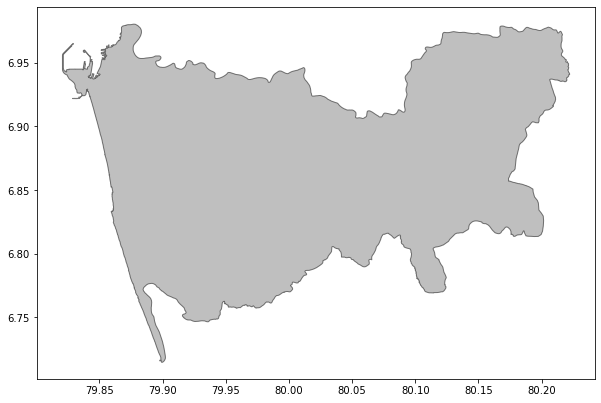

In [100]:
fig, ax = plt.subplots(figsize=(10,15))
colombo_district.plot(ax=ax, facecolor ='gray', alpha = 0.5,  edgecolor='black')

<AxesSubplot:>

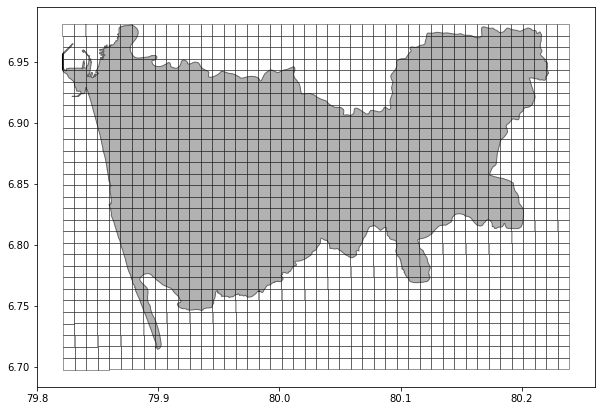

In [101]:
fig, ax = plt.subplots(figsize=(10,15))
colombo_district.plot(ax=ax, facecolor='gray', edgecolor='black')
grids.plot(ax=ax,facecolor ='white', alpha = 0.4,  edgecolor='black')

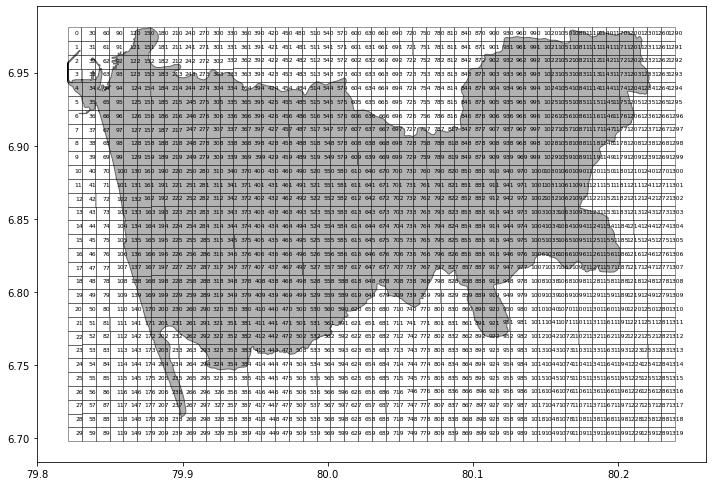

In [102]:
fig, ax = plt.subplots(figsize=(10,15))

colombo_district.plot(ax=ax, facecolor='gray', edgecolor='black')
grids.plot(ax=ax,facecolor ='white', alpha = 0.4,  edgecolor='black')

for ID, grid in enumerate(grids['geometry']):
    grid_center = grid.centroid
    ax.annotate(ID, xy= (grid_center.bounds[0] ,grid_center.bounds[1]), fontsize = 6)
    

plt.tight_layout()

In [103]:
# intersect the selected study area and the grid structure
captured_grids = gpd.overlay(grids,colombo_district , how='intersection')

<ipython-input-103-041560465889>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  captured_grids = gpd.overlay(grids,colombo_district , how='intersection')


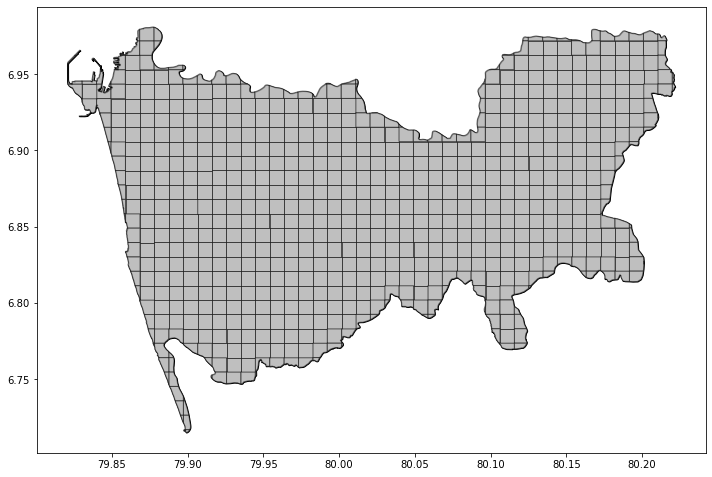

In [105]:
fig, ax = plt.subplots(figsize=(10,15))
colombo_district.plot(ax=ax, facecolor='gray', edgecolor='black')
captured_grids.plot(ax=ax,facecolor ='white', alpha = 0.5,  edgecolor='black')
plt.tight_layout()

### Identifying the center location for each grid

In [106]:
for ID, grid in enumerate(captured_grids['geometry']):
        grid_center = grid.centroid
        captured_grids.loc[ID,'Center_X'] = grid_center.bounds[0]
        captured_grids.loc[ID,'Center_Y'] = grid_center.bounds[1]

In [107]:
captured_grids

,ADM2_EN,ADM2_SI,ADM2_TA,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM2ALT1SI,ADM2ALT2SI,ADM2ALT1TA,...,ADM0_TA,ADM0_PCODE,Shape_Leng,Shape_Area,date,validOn,validTo,geometry,Center_X,Center_Y
0,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((79.82624 6.96217, 79.82524 6.96217, ...",79.827128,6.963652
1,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((79.82524 6.96217, 79.82624 6.96217, ...",79.822906,6.958903
2,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"MULTIPOLYGON (((79.83032 6.94548, 79.83032 6.9...",79.825804,6.944691
3,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((79.82348 6.94329, 79.83035 6.94329, ...",79.827171,6.940034
4,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((79.82992 6.93387, 79.83035 6.93387, ...",79.830234,6.933130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((80.21045 6.94344, 80.21045 6.95289, ...",80.215105,6.948093
729,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((80.21045 6.93694, 80.21045 6.94344, ...",80.215261,6.939849
730,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((80.21048 6.92084, 80.21048 6.92358, ...",80.210554,6.922121
731,Colombo,කොළඹ දිස්ත්‍රික්ක,கொழும்பு மாவட்டம்,LK11,None,None,None,None,None,None,...,இலங்கை,LK,1.887285,0.056092,2019-03-04,2020-03-05,None,"POLYGON ((80.21995 6.94344, 80.21995 6.95136, ...",80.220378,6.947121


In [110]:
captured_grids = captured_grids[['geometry','Center_X','Center_Y','ADM2_EN']]

In [111]:
captured_grids = captured_grids.reset_index()

In [113]:
captured_grids.to_file("GRID/centered_colombo_filtered_grid_50.shp")

# Places API Call